# Is [Dask `Delayed`](https://docs.dask.org/en/latest/delayed.html) a Monad?
[Dask](https://dask.org/) is a very cool Python library, and one of its core abstractions is the "[Delayed](https://docs.dask.org/en/latest/delayed.html)" container.

`delayed`:
- wraps values
- records subsequent operations on these wrapped values (without performing the operations)
- lets you think you are working with raw values

Meanwhile, it builds a graph of your program, providing opportunities to [visualize](https://docs.dask.org/en/latest/graphviz.html), [optimize](https://docs.dask.org/en/latest/optimize.html), and [parallelize](https://distributed.dask.org/en/latest/) your computations.

## Contexualizing Dask Delayed
Delayed clearly looks like abstractions found in other contexts; it provides "laziness" and "provenance", and I've guessed that it's a [Monad](https://en.wikipedia.org/wiki/Monad_(functional_programming) (though the API doesn't make that obvious).

I recently needed to do [some relatively intricate Dask-graph manipulations](https://nbviewer.jupyter.org/gist/ryan-williams/0aeb2111cb8b7fd588784e2a7c35433e/chain-example.ipynb), and had trouble ekeing simple monadic transformations out of Dask's APIs, so here I'll compare [`Delayed`](https://docs.dask.org/en/latest/delayed.html) to a few relevant to [category-theoretic](https://en.wikipedia.org/wiki/Category_theory) concepts (as implemented in [Scala's "Cats" library](https://typelevel.org/cats)):
- [**`Delayed` is an Applicative**](#applicative)
  - [`pure`](#pure)
  - [`map`](#map)
  - [`ap`](#ap)
- [**`Delayed is a Monad**](#monad)
  - [`flatten`](#flatten)
  - [`flatMap`](#flatMap)
- [**Discussion**](#discussion)
  - [Sequencing computations](#sequencing)
    - [Example: task-chaining](#chaining)
  - [Dynamic task graphs](#dynamic-graphs)

In [1]:
from dask import delayed

--------
## Delayed is an [Applicative](https://typelevel.org/cats/typeclasses/applicative.html#applicative) <a id="applicative"></a>
[Applicatives](https://typelevel.org/cats/typeclasses/applicative.html#applicative) support 3 operations:

| Name | Type | Notes |
| ---- | ---- | ----- |
| `pure` | `A ⇒ F[A]` | Lift any value into the `Delayed` container |
| `ap` | `(F[A], F[A ⇒ B]) ⇒ F[B]` | Apply a `Delayed` function to a `Delayed` value and obtain a `Delayed` result |
| `map` | `(F[A], A ⇒ B) ⇒ F[B]` | Apply a function to a `Delayed` value and obtain a `Delayed` result |

See examples below:
### `pure` <a id="pure"></a>
`A ⇒ F[A]`; lift any value into the `Delayed` container:

In [2]:
a = 4
fa = delayed(a); fa

Delayed('int-fdb51b88-bca5-44de-b591-6d98f19b6497')

"Unboxing", just to check:

In [3]:
fa.compute()

4

A "generic" implementation is trivial:

In [4]:
def pure(a): return delayed(a)

As we see, `delayed` itself is the simplest generic implementation of the `pure` capability:

In [5]:
pure = delayed

### `ap` <a id="ap"></a>
`(F[A], F[A ⇒ B]) ⇒ F[B]`; apply a `Delayed` function to a `Delayed` value and obtain a `Delayed` result

In [6]:
_hex = delayed(hex)  # F[int ⇒ str]: a delayed function from an int to a str
fb = _hex(fa); fb

Delayed('hex-38be2eca-d878-44fd-bc9e-7749e355a8a5')

In [7]:
fb.compute()

'0x4'

We passed a `Delayed` value to a `Delayed` function and the two levels of "delay" were "flattened" into the usual/desired one level, so that a single `.compute()` returns the value.

🆒😎

The generic implementation is again trivial:

In [8]:
ap = lambda fa, f_a_b: f_a_b(fa)

### `map`
`(F[A], A ⇒ B) ⇒ F[B]`; apply a function to a `Delayed` value and obtain a `Delayed` result

This is the defining capability of a [Functor](https://typelevel.org/cats/typeclasses/functor.html), which [Applicatives](https://typelevel.org/cats/typeclasses/applicative.html#applicative) implement, and is conceptually simpler than [`ap`](#ap).

However, it's not obvious how to do in Dask, at least directly. Dask really wants to work with `Delayed` functions, not feed `Delayed` values directly to eager functions.

Luckily, [`pure`](#pure) and [`ap`](#ap) are sufficient to implement `map` (which also explains why [`Applicative`s](https://typelevel.org/cats/typeclasses/applicative.html#applicative) are [`Functor`s](https://typelevel.org/cats/typeclasses/functor.html)):

In [9]:
map = lambda fa, a_b: delayed(a_b)(fa)

Example:

In [10]:
fb = map(fa, hex); fb

Delayed('hex-3d16e63e-8790-4680-9c71-be3bf71ac3dc')

In [11]:
fb.compute()

'0x4'

Here we turned an `F[int]` and an `int ⇒ str` into an `F[str]` 👍

-------
## Is `Delayed` a [Monad](https://typelevel.org/cats/typeclasses/monad.html)? <a id="monad"></a>
Great, `Delayed` is an [Applicative](https://typelevel.org/cats/typeclasses/applicative.html#applicative) (and a [Functor](https://typelevel.org/cats/typeclasses/functor.html)); but is it a [Monad](https://typelevel.org/cats/typeclasses/monad.html)?

According to [Cats' Monad docs](https://typelevel.org/cats/typeclasses/monad.html#monad):
> `Monad` extends the `Applicative` type class with a new function `flatten`. Flatten takes a value in a nested context (eg. `F[F[A]]` where F is the context) and “joins” the contexts together so that we have a single context (ie. `F[A]`).

So all we need to prove `Delayed`'s monadicity is `flatten`!

### `flatten` <a id="flatten"></a>
`F[F[A]] ⇒ F[A]`: "join" two levels of `Delayed` into one

(Note: this operation is commonly called "join" as well)

Naively, we can always remove a layer of `F[_]` wrapping by calling `.compute()` (which has type `F[A] ⇒ [A]`):

In [12]:
fa.compute()  # F[int] ⇒ int

4

In principle flattening is as simple as:

In [13]:
def flatten(fa): return fa.compute()  # F[A] ⇒ A

We know this works for `F[A] ⇒ A`, but what about `F[F[A]] ⇒ F[A]`?

Substituting "`F[A]`" for "`A`" in the type `F[A] ⇒ A` yields `F[F[A]] ⇒ F[A]`, indicating that it *should* work, but let's try to construct an `F[F[A]]` to test it:

In [14]:
ffa = delayed(fa); ffa

Delayed('int-fdb51b88-bca5-44de-b591-6d98f19b6497')

It turns out that `delayed` is clever, and has short-circuited the double-wrap here. A single `.compute()` gives us our value back:

In [15]:
ffa.compute()

4

However, we can still pull one over on `delayed`:

In [16]:
ffa = delayed(lambda a: delayed(a))(a); ffa

Delayed('lambda-3e297b56-1348-49ca-b3a2-7ad5a0b9a7d5')

`ffa` is truly of type `F[F[A]]`; calling `.compute()` gives us an `F[A]` (still Delayed!):

In [17]:
ffa.compute()

Delayed('int-174298a5-f846-4c8d-8b51-166eff6c0dd4')

Calling `.compute()` twice yields our original value again:

In [18]:
ffa.compute().compute()

4

Clearly, `flatten` (a.k.a. `compute`) is possible for Delayed objects! So…

#### 🎉🎉 `Delayed` is a monad! 🎉🎉

### `flatMap` <a id="flatMap"></a>
`(F[A], A ⇒ F[B]) ⇒ F[B]`

For completeness, let's discuss `flatMap`.

#### intro
`flatMap` is typically the core behavior of a Monad:
- a `Delayed` value (`F[A]`) is fed to a function
- that function, roughly:
  - enters the `F` "box" where the actual `A` value is
  - transforms the `A` to a `B` *while introducing a second level of delay/wrapping* (`A ⇒ F[B]`)
  - leaves the box (meaning now we expect to be doubly-nested in two layers of `F[_]`, with an `F[F[B]]`)!.

#### magic
Yet, somehow, the magic of `flatMap` yields a transformed – but only singly-wrapped – value (`F[B]`).

This "magic" – the specifics of *how* a monad takes something doubly-wrapped, and unwraps a layer (or, more commonly, fakes it and lets you carry on as if it has) – is what defines the big, famous, common monads:

- Maybe (a.k.a. Option)
- Future (a.k.a. Promise; see also async/await)
- List, Set
- Try (like Option, but stores+propagates an error)
- IO, Lazy (basically what Dask Delayed does)

#### deriving from `map`, `flatten`
With all that said, `flatMap` is trivially implementable in terms of `map` and `flatten`:

In [19]:
flatMap = lambda fa, a_fb: flatten(map(fa, a_fb))

Testing:

In [20]:
int_to_delayed_str = lambda a: delayed(hex(a))

flatMap(fa, int_to_delayed_str).compute()

'0x4'

Hooray!

## Discussion <a id="discussion"></a>

### Sequencing computations <a id="sequencing"></a>
A defining characteristic of Monads is that they support *sequencing* computations (i.e. running things in serial, one after another).

That's ironic given Dask's focus on parallel computation, but nevertheless frequently useful.

The intuition for why that is can be found in the signature of [`flatMap`](#flatMap):
```
(F[A], A ⇒ F[B]) ⇒ F[B]
```
You start with one computation (`F[A]`), and you end with another (`F[B]`); could they both be running concurrently at some point?

The answer is no: the second computation, `F[B]`, is never created (or introduced into the task graph) until the function `A ⇒ F[B]` has completed, and the `A` from the original `F[A]` must be available, and unboxed, before `A ⇒ F[B]` can happen!

#### Case study: "chaining" tasks <a id="chaining"></a>
Let's leverage this "sequencing" property to construct a function that, given two tasks `F[A]` and `F[B]`, will run `F[A]` to completion, then `F[B]`, and return both values (`(F[A], F[B]) ⇒ (A, B)`):

In [21]:
from time import sleep
def id(x):
    '''Simple function that returns the value it's passed
    
    It also prints its progress, and sleeps on a certain value
    (which we'll pass first, to verify tasks aren't running
    concurrently)'''

    print(f'computing: {x}')
    if x == 'A':
        print(f'Sleeping…')
        sleep(1)
    print(f'computed: {x}')
    return x

id = delayed(id)

# Sample "delayed" values
fa = id('A', dask_key_name='idA')
fb = id('B', dask_key_name='idB')

In [22]:
def sequence(fa, fb):
    # Helper which receives a computed `a`, and in turn computes `b`
    _sequence = lambda a: (a, fb.compute())

    name = f"combine_{fb._key}"
    return delayed(_sequence)(fa, dask_key_name=name)

In [23]:
res = sequence(fa, fb); res

Delayed('combine_idB')

In [24]:
res.compute()

computing: A
Sleeping…
computed: A
computing: B
computed: B


('A', 'B')

We can see the task graph shows `A` being computed, and then combined with `B`:

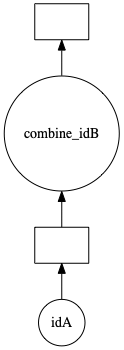

In [25]:
res.visualize()

(the original `B` node does not appear on its own in Dask's view of this computation; it is "side-loaded" by the `combine_idB` node, but that is OK!)

### Dynamic Task Graphs <a id="dynamic-graphs"></a>
Another defining characteristic of "task Monads" is that they allow for "dynamic dependency graphs", where the information about dependencies between nodes (and even what nodes exist!) is only available "at run-time" (as other nodes are executed.

Note that this doesn't mean all nodes' in a given task graph leverage this dynamicism, simply that it is possible.

For example, imagine a workflow that involves performing some computation that outputs a number, and performing some other step that number of times (or using that many partitions); the latter task nodes are only created when execution of their ancestors has completed!

The implications of such dynamicism is examined in the delightful ["Build Systems a la Carte" (Mokhov 2019)](https://www.microsoft.com/en-us/research/uploads/prod/2018/03/build-systems-final.pdf), which is well worth a read.

This means that Dask task graphs can be entirely dynamic; does this occur in the wild? It seems doubtful, but certainly something that may be worth making more explicit + streamlined.

Thanks for reading!